In [3]:
%pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 20.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.6/269.6 kB 8.1 MB/s eta 0:00:00
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 21.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 20.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 3.9 MB/s eta 0:00:00

[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



Custom Protocol Benchmarks (total time for 10000 iterations):
handle_create: 0.009170 sec, avg: 0.92 µs, message size: 33 bytes
handle_login: 0.006503 sec, avg: 0.65 µs, message size: 33 bytes
get_conversations: 0.005181 sec, avg: 0.52 µs, message size: 33 bytes
get_chat_history: 0.006482 sec, avg: 0.65 µs, message size: 13 bytes
send_message: 0.005467 sec, avg: 0.55 µs, message size: 9 bytes
delete_messages: 0.004319 sec, avg: 0.43 µs, message size: 24 bytes
delete_account: 0.002693 sec, avg: 0.27 µs, message size: 14 bytes
process_message: 0.015008 sec, avg: 1.50 µs, message size: 33 bytes

JSON Protocol Benchmarks (total time for 10000 iterations):
handle_create: 0.060373 sec, avg: 6.04 µs, message size: 70 bytes
handle_login: 0.032935 sec, avg: 3.29 µs, message size: 70 bytes
get_conversations: 0.031448 sec, avg: 3.14 µs, message size: 70 bytes
get_chat_history: 0.031239 sec, avg: 3.12 µs, message size: 44 bytes
send_message: 0.055182 sec, avg: 5.52 µs, message size: 37 bytes
dele

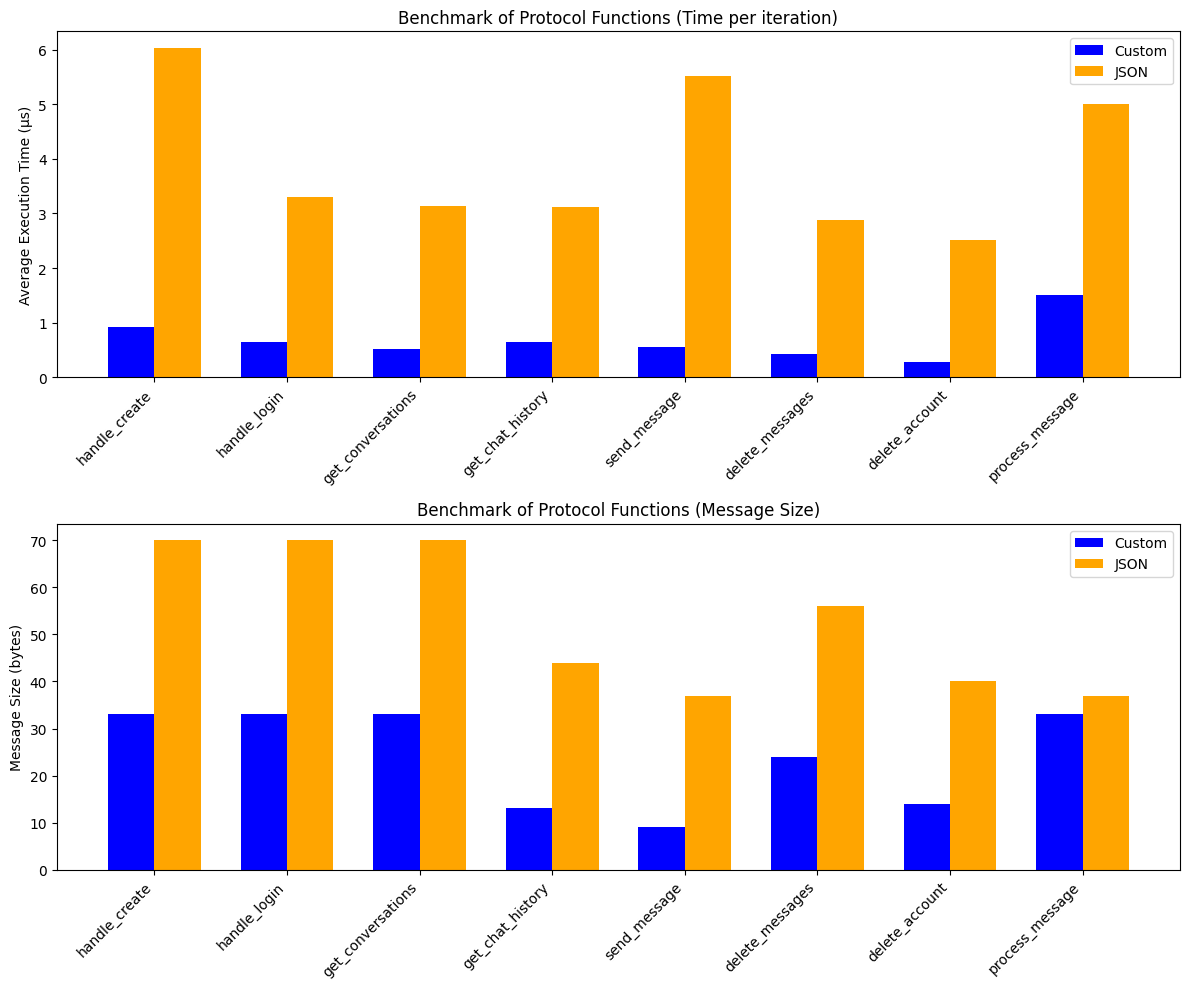

In [17]:
import json
import timeit
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

# We use os.getcwd() to get the current working directory.
current_dir = os.getcwd()  # or manually set this if needed
project_root = os.path.abspath(os.path.join(current_dir, '..'))
server_dir = os.path.join(project_root, 'server')

# Optionally, add the project root to sys.path so Python can find your modules.
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Change directory to the server directory if necessary
os.chdir(server_dir)

from configs.config import *

# ----- Dummy Dependencies & Constants -----
class DummyDB:
    def register_account(self, username, password):
        return True, None
    def verify_login(self, username, password):
        return True, None
    def get_conversations(self, recipient):
        return [("otheruser", 0)]
    def get_recent_messages(self, client, user2, oldest_msg_id, limit):
        # Return 0 unreads and an empty history for simplicity
        return 0, []
    def store_message(self, sender, recipient, message):
        return 1
    def delete_message(self, id):
        return ("otheruser", "testuser", 0, None)
    def deactivate_account(self, username):
        return True
    def mark_message_as_read(self, msg_id):
        pass

dummy_db = DummyDB()
active_clients = {}  # no active clients for these benchmarks

# ----- CUSTOM PROTOCOL FUNCTIONS -----
def custom_parse_message(message):
    tokens = message.strip().split()
    if len(tokens) < 2:
        return None, None, []
    version = tokens[0]
    command = tokens[1].upper()
    args = tokens[2:]
    return version, command, args

def custom_handle_create(args):
    username, password = args[0], args[1]
    success, errno = dummy_db.register_account(username, password)
    if success:
        push_user = f"1.0 PUSH_USER {username}"
        for user, sock in active_clients.items():
            if user != username:
                try:
                    debug(f"Server: pushing message: {push_user}")
                except Exception as e:
                    print(e)
        return custom_get_conversations(username, REG_PG)
    else:
        return f"1.0 ERROR {errno}"

def custom_handle_login(args):
    username, password = args[0], args[1]
    success, errno = dummy_db.verify_login(username, password)
    if username in active_clients:
        return f"1.0 ERROR {USER_LOGGED_ON}"
    if success:
        return custom_get_conversations(username, LGN_PG)
    else:
        return f"1.0 ERROR {errno}"

def custom_get_conversations(recipient, page_code):
    response = f"1.0 USERS {page_code} {recipient}"
    for user, unread in dummy_db.get_conversations(recipient):
        response += f" {user} {unread}"
    return response

def custom_get_chat_history(args):
    client = args[0]
    user2 = args[1]
    oldest_msg_id = int(args[2])
    num_msgs = int(args[3])
    page_code = MSG_PG if oldest_msg_id != -1 else CONVO_PG
    unreads, history = dummy_db.get_recent_messages(client, user2, oldest_msg_id, num_msgs)
    response = f"1.0 MSGS {page_code} {unreads}"
    if not history:
        return response
    # For simplicity, we assume a dummy flag and message count.
    is_client = 1  
    response = f"{response} {is_client}"
    num_messages = 0
    formatted_messages = ""
    for message in history:
        num_messages += 1
        message_text = message.get("message", "")
        id_val = message.get("id", 0)
        num_words = len(message_text.split())
        cur_msg = f" {id_val} {num_words} {message_text}"
        formatted_messages += cur_msg
    formatted_messages = f" {num_messages}{formatted_messages}"
    response += formatted_messages
    return response

def custom_send_message(args):
    msg_id = -1
    sender = args[0]
    recipient = args[1]
    message = ' '.join(args[2:])
    msg_id = dummy_db.store_message(sender, recipient, message)
    push_message = f"1.0 PUSH_MSG {sender} {msg_id} {message}\n"
    if recipient in active_clients:
        try:
            debug(f"Server: pushing message: {message}")
        except Exception as e:
            print(e)
    return f"1.0 ACK {msg_id}"

def custom_delete_messages(args):
    id_val = int(args[0])
    recipient, sender, unread, errno = dummy_db.delete_message(id_val)
    if recipient:
        response = f"1.0 DEL_MSG {id_val} {sender} {unread}"
        return response
    else:
        return f"1.0 ERROR {errno}"

def custom_delete_account(args):
    username = args[0]
    errno = dummy_db.deactivate_account(username)
    if errno == SUCCESS:
        active_clients.pop(username, None)
        return '1.0 DEL_ACC'
    else:
        return f"1.0 ERROR {errno}"

def custom_received_message(args):
    msg_id = int(args[0])
    dummy_db.mark_message_as_read(msg_id)
    return None  # No message returned

def custom_process_message(message):
    version, command, args = custom_parse_message(message)
    if version not in SUPPORTED_VERSIONS:
        return f"1.0 ERROR {UNSUPPORTED_VERSION}"
    if command == "CREATE":
        return custom_handle_create(args)
    elif command == "LOGIN":
        return custom_handle_login(args)
    elif command == "READ":
        return custom_get_chat_history(args)
    elif command == "SEND":
        return custom_send_message(args)
    elif command == "DEL_MSG":
        return custom_delete_messages(args)
    elif command == "DEL_ACC":
        return custom_delete_account(args)
    elif command == "REC_MSG":
        return custom_received_message(args)
    else:
        return f"1.0 ERROR {UNKNOWN_COMMAND}"

# ----- JSON PROTOCOL FUNCTIONS -----
def json_wrap_message(opcode, data):
    return f"{CUR_PROTO_VERSION} {json.dumps({'opcode': opcode, 'data': data})}\n"

def json_parse_message(message):
    try:
        tokens = message.strip().split(' ', 1)
        if len(tokens) < 2:
            return None, None, []
        version = tokens[0]
        json_part = tokens[1]
        msg_obj = json.loads(json_part)
        opcode = msg_obj.get("opcode")
        data = msg_obj.get("data", [])
        return version, opcode, data
    except Exception:
        return None, None, []

def json_handle_create(data):
    username, password = data[0], data[1]
    success, errno = dummy_db.register_account(username, password)
    if success:
        push_user = json_wrap_message("PUSH_USER", [username])
        for user, sock in active_clients.items():
            if user != username:
                try:
                    debug(f"Server: pushing message: {push_user}")
                except Exception as e:
                    print(e)
        return json_get_conversations(username, REG_PG)
    else:
        return json_wrap_message("ERROR", [errno])

def json_handle_login(data):
    username, password = data[0], data[1]
    success, errno = dummy_db.verify_login(username, password)
    if username in active_clients:
        return json_wrap_message("ERROR", [USER_LOGGED_ON])
    if success:
        return json_get_conversations(username, LGN_PG)
    else:
        return f"1.0 ERROR {errno}"

def json_get_conversations(recipient, page_code):
    data_list = [str(page_code), recipient]
    for user, unread in dummy_db.get_conversations(recipient):
        data_list.extend([user, str(unread)])
    return json_wrap_message("USERS", data_list)

def json_get_chat_history(data):
    client = data[0]
    user2 = data[1]
    oldest_msg_id = int(data[2])
    num_msgs = int(data[3])
    page_code = MSG_PG if oldest_msg_id != -1 else CONVO_PG
    unreads, history = dummy_db.get_recent_messages(client, user2, oldest_msg_id, num_msgs)
    data_list = [str(page_code), str(unreads)]
    if not history:
        return json_wrap_message("MSGS", data_list)
    is_client = 1  # dummy value
    data_list.append(str(is_client))
    num_messages = 0
    formatted_messages = []
    for message in history:
        num_messages += 1
        message_text = message.get("message", "")
        msg_id = message.get("id", 0)
        num_words = len(message_text.split())
        formatted_messages.extend([str(msg_id), str(num_words), message_text])
    formatted_messages.insert(0, str(num_messages))
    data_list.extend(formatted_messages)
    return json_wrap_message("MSGS", data_list)

def json_send_message(data):
    msg_id = -1
    sender = data[0]
    recipient = data[1]
    message = ' '.join(data[2:])
    msg_id = dummy_db.store_message(sender, recipient, message)
    push_message = json_wrap_message("PUSH_MSG", [sender, str(msg_id), message])
    if recipient in active_clients:
        try:
            debug(f"Server: pushing message: {push_message}")
        except Exception as e:
            print(e)
    return json_wrap_message("ACK", [str(msg_id)])

def json_delete_messages(data):
    msg_id = int(data[0])
    recipient, sender, unread, errno = dummy_db.delete_message(msg_id)
    if recipient:
        response = json_wrap_message("DEL_MSG", [str(msg_id), sender, unread])
        return response
    else:
        return json_wrap_message("ERROR", [errno])

def json_delete_account(data):
    username = data[0]
    errno = dummy_db.deactivate_account(username)
    if errno == SUCCESS:
        active_clients.pop(username, None)
        return json_wrap_message("DEL_ACC", [])
    else:
        return json_wrap_message("ERROR", [errno])

def json_received_message(data):
    msg_id = int(data[0])
    dummy_db.mark_message_as_read(msg_id)
    return None

def json_process_message(message):
    version, opcode, data = json_parse_message(message)
    if version != CUR_PROTO_VERSION:
        return json_wrap_message("ERROR", [UNSUPPORTED_VERSION])
    if opcode == "CREATE":
        return json_handle_create(data)
    elif opcode == "LOGIN":
        return json_handle_login(data)
    elif opcode == "READ":
        return json_get_chat_history(data)
    elif opcode == "SEND":
        return json_send_message(data)
    elif opcode == "DEL_MSG":
        return json_delete_messages(data)
    elif opcode == "DEL_ACC":
        return json_delete_account(data)
    elif opcode == "REC_MSG":
        return json_received_message(data)
    else:
        return json_wrap_message("ERROR", [UNKNOWN_COMMAND])

# ----- Benchmark Wrappers & Setup -----
n_runs = 10000

# Sample message strings and argument lists for testing:
msg_custom = "1.0 LOGIN testuser secret\n"
msg_json = f"2.0 {json.dumps({'opcode': 'LOGIN', 'data': [ 'testuser', 'secret']})}\n"

args_create = ["testuser", "secret"]
args_login = ["testuser", "secret"]
args_get_conversations = ("testuser", LGN_PG)
args_get_chat_history = ["testuser", "otheruser", "-1", "10"]
args_send_message = ["testuser", "otheruser", "Hello world"]
args_delete_messages = ["1"]
args_delete_account = ["testuser"]
args_received_message = ["1"]

# --- Benchmark wrappers for Custom Protocol functions ---
def benchmark_custom_parse_message():
    return custom_parse_message(msg_custom)

def benchmark_custom_handle_create():
    return custom_handle_create(args_create)

def benchmark_custom_handle_login():
    return custom_handle_login(args_login)

def benchmark_custom_get_conversations():
    return custom_get_conversations(*args_get_conversations)

def benchmark_custom_get_chat_history():
    return custom_get_chat_history(args_get_chat_history)

def benchmark_custom_send_message():
    return custom_send_message(args_send_message)

def benchmark_custom_delete_messages():
    return custom_delete_messages(args_delete_messages)

def benchmark_custom_delete_account():
    return custom_delete_account(args_delete_account)

def benchmark_custom_received_message():
    return custom_received_message(args_received_message)

def benchmark_custom_process_message():
    return custom_process_message(msg_custom)

# --- Benchmark wrappers for JSON Protocol functions ---
def benchmark_json_parse_message():
    return json_parse_message(msg_json)

def benchmark_json_handle_create():
    return json_handle_create(args_create)

def benchmark_json_handle_login():
    return json_handle_login(args_login)

def benchmark_json_get_conversations():
    return json_get_conversations("testuser", LGN_PG)

def benchmark_json_get_chat_history():
    return json_get_chat_history(args_get_chat_history)

def benchmark_json_send_message():
    return json_send_message(args_send_message)

def benchmark_json_delete_messages():
    return json_delete_messages(args_delete_messages)

def benchmark_json_delete_account():
    return json_delete_account(args_delete_account)

def benchmark_json_received_message():
    return json_received_message(args_received_message)

def benchmark_json_process_message():
    return json_process_message(msg_json)

# ----- Run Time Benchmarks -----
custom_benchmarks = {
    "handle_create": timeit.timeit(benchmark_custom_handle_create, number=n_runs),
    "handle_login": timeit.timeit(benchmark_custom_handle_login, number=n_runs),
    "get_conversations": timeit.timeit(benchmark_custom_get_conversations, number=n_runs),
    "get_chat_history": timeit.timeit(benchmark_custom_get_chat_history, number=n_runs),
    "send_message": timeit.timeit(benchmark_custom_send_message, number=n_runs),
    "delete_messages": timeit.timeit(benchmark_custom_delete_messages, number=n_runs),
    "delete_account": timeit.timeit(benchmark_custom_delete_account, number=n_runs),
    "process_message": timeit.timeit(benchmark_custom_process_message, number=n_runs),
}

json_benchmarks = {
    "handle_create": timeit.timeit(benchmark_json_handle_create, number=n_runs),
    "handle_login": timeit.timeit(benchmark_json_handle_login, number=n_runs),
    "get_conversations": timeit.timeit(benchmark_json_get_conversations, number=n_runs),
    "get_chat_history": timeit.timeit(benchmark_json_get_chat_history, number=n_runs),
    "send_message": timeit.timeit(benchmark_json_send_message, number=n_runs),
    "delete_messages": timeit.timeit(benchmark_json_delete_messages, number=n_runs),
    "delete_account": timeit.timeit(benchmark_json_delete_account, number=n_runs),
    "process_message": timeit.timeit(benchmark_json_process_message, number=n_runs),
}

# ----- Measure Message Sizes -----
def get_message_size(result):
    if isinstance(result, str):
        return len(result.encode('utf-8'))
    return 0

custom_msg_sizes = {
    "handle_create": get_message_size(benchmark_custom_handle_create()),
    "handle_login": get_message_size(benchmark_custom_handle_login()),
    "get_conversations": get_message_size(benchmark_custom_get_conversations()),
    "get_chat_history": get_message_size(benchmark_custom_get_chat_history()),
    "send_message": get_message_size(benchmark_custom_send_message()),
    "delete_messages": get_message_size(benchmark_custom_delete_messages()),
    "delete_account": get_message_size(benchmark_custom_delete_account()),
    "process_message": get_message_size(benchmark_custom_process_message()),
}

json_msg_sizes = {
    "handle_create": get_message_size(benchmark_json_handle_create()),
    "handle_login": get_message_size(benchmark_json_handle_login()),
    "get_conversations": get_message_size(benchmark_json_get_conversations()),
    "get_chat_history": get_message_size(benchmark_json_get_chat_history()),
    "send_message": get_message_size(benchmark_json_send_message()),
    "delete_messages": get_message_size(benchmark_json_delete_messages()),
    "delete_account": get_message_size(benchmark_json_delete_account()),
    "process_message": get_message_size(benchmark_json_process_message()),
}

# Print benchmark results
print("\nCustom Protocol Benchmarks (total time for {} iterations):".format(n_runs))
for fn, t in custom_benchmarks.items():
    avg = t/n_runs*1e6
    size = custom_msg_sizes[fn]
    print(f"{fn}: {t:.6f} sec, avg: {avg:.2f} µs, message size: {size} bytes")

print("\nJSON Protocol Benchmarks (total time for {} iterations):".format(n_runs))
for fn, t in json_benchmarks.items():
    avg = t/n_runs*1e6
    size = json_msg_sizes[fn]
    print(f"{fn}: {t:.6f} sec, avg: {avg:.2f} µs, message size: {size} bytes")

# ----- Plotting the Benchmark Results -----
function_names = list(custom_benchmarks.keys())
custom_times = [custom_benchmarks[fn] / n_runs * 1e6 for fn in function_names]  # avg time in µs
json_times   = [json_benchmarks[fn] / n_runs * 1e6 for fn in function_names]

custom_sizes = [custom_msg_sizes[fn] for fn in function_names]
json_sizes   = [json_msg_sizes[fn] for fn in function_names]

x = np.arange(len(function_names))
width = 0.35

fig, (ax_time, ax_size) = plt.subplots(2, 1, figsize=(12, 10))

# Bar plot for execution time
rects1 = ax_time.bar(x - width/2, custom_times, width, label='Custom', color='blue')
rects2 = ax_time.bar(x + width/2, json_times, width, label='JSON', color='orange')
ax_time.set_ylabel('Average Execution Time (µs)')
ax_time.set_title('Benchmark of Protocol Functions (Time per iteration)')
ax_time.set_xticks(x)
ax_time.set_xticklabels(function_names, rotation=45, ha='right')
ax_time.legend()

# Bar plot for message sizes
rects3 = ax_size.bar(x - width/2, custom_sizes, width, label='Custom', color='blue')
rects4 = ax_size.bar(x + width/2, json_sizes, width, label='JSON', color='orange')
ax_size.set_ylabel('Message Size (bytes)')
ax_size.set_title('Benchmark of Protocol Functions (Message Size)')
ax_size.set_xticks(x)
ax_size.set_xticklabels(function_names, rotation=45, ha='right')
ax_size.legend()

plt.tight_layout()
plt.show()

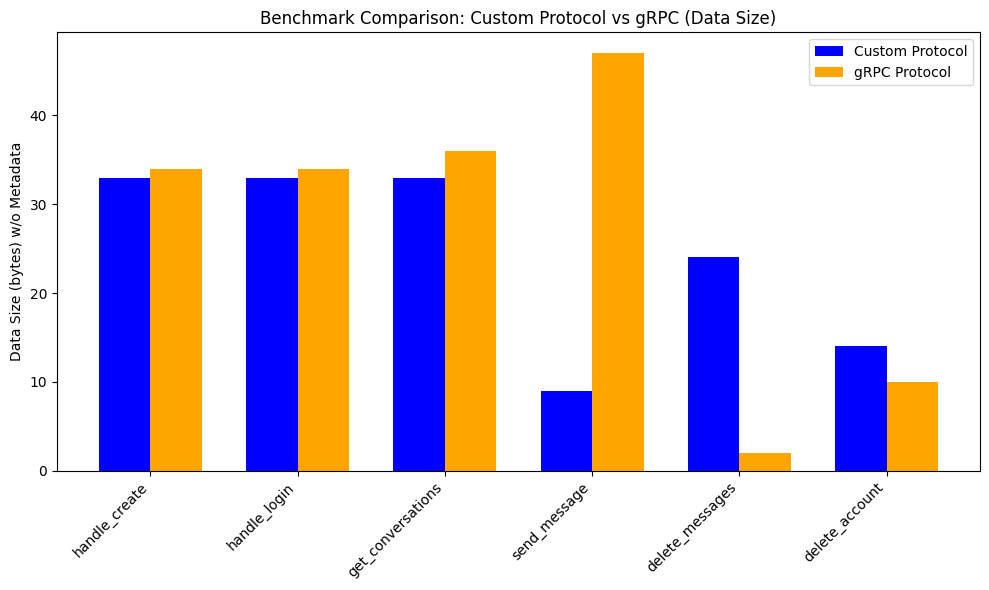

In [33]:
import timeit
import grpc
import sys
import os
import pickle

# Get the absolute path of the current working directory
notebook_dir = os.getcwd()

# Ensure the directory containing chat_service_pb2.py is in sys.path
sys.path.insert(0, notebook_dir)
import chat_service_pb2
import chat_service_pb2_grpc
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
from server.protocols import custom_protocol
from server import database
from server.database import initialize_db
from concurrent import futures
from server.protocols.grpc_server_protocol import MyChatService

def start_grpc_server():
    server = grpc.server(futures.ThreadPoolExecutor(max_workers=10))
    chat_service_pb2_grpc.add_ChatServiceServicer_to_server(MyChatService(), server)
    port = server.add_insecure_port("[::]:50051")
    server.start()
    return server

# Setup gRPC stub
def get_grpc_stub():
    channel = grpc.insecure_channel("localhost:50051")
    return chat_service_pb2_grpc.ChatServiceStub(channel)

# Start the gRPC server
server = start_grpc_server()
stub = get_grpc_stub()

initialize_db()

# Number of iterations for benchmarking
n_runs = 10000

# Sample test data
username = "testuser"
password = "password"
test_message = "Hello, benchmark test!"
msg_id = 1

# Function to calculate message size
def get_size(obj, meta=False):
    if meta:
        return len(pickle.dumps(obj))
    return len(obj.SerializeToString())

# Benchmarking gRPC Protocol
def grpc_register_request(meta=False):
    request = chat_service_pb2.RegisterRequest(username=username, password=password, ip_address="127.0.0.1", port=5000)
    size = get_size(request, meta=meta)
    return size

def benchmark_grpc_login(meta=False):
    request = chat_service_pb2.LoginRequest(username=username, password=password, ip_address="127.0.0.1", port=5000)
    size = get_size(request, meta=meta)
    return size

def benchmark_grpc_send_message(meta=False):
    request = chat_service_pb2.SendMessageRequest(sender=username, recipient="anotheruser", text=test_message)
    size = get_size(request, meta=meta)
    return size

def benchmark_grpc_get_chat_history(meta=False):
    request = chat_service_pb2.ChatHistoryRequest(username=username, other_user="anotheruser", num_msgs=10, oldest_msg_id=-1)
    size = get_size(request, meta=meta)
    return size

def benchmark_grpc_delete_account(meta=False):
    request = chat_service_pb2.DeleteAccountRequest(username=username)
    size = get_size(request, meta=meta)
    return size

def benchmark_grpc_delete_message(meta=False):
    request = chat_service_pb2.DeleteMessageRequest(msg_id=msg_id)
    size = get_size(request, meta=meta)
    return size

grpc_sizes = {
    "handle_create": grpc_register_request(),
    "handle_login": benchmark_grpc_login(),
    "get_conversations": benchmark_grpc_get_chat_history(),
    "send_message": benchmark_grpc_send_message(),
    "delete_messages": benchmark_grpc_delete_message(),
    "delete_account": benchmark_grpc_delete_account(),
}
custom_sizes = {
    "handle_create": get_message_size(benchmark_custom_handle_create()),
    "handle_login": get_message_size(benchmark_custom_handle_login()),
    "get_conversations": get_message_size(benchmark_custom_get_conversations()),
    "send_message": get_message_size(benchmark_custom_send_message()),
    "delete_messages": get_message_size(benchmark_custom_delete_messages()),
    "delete_account": get_message_size(benchmark_custom_delete_account()),
}

# Visualization
custom_data_sizes = [custom_sizes[fn] for fn in custom_sizes.keys()]
grpc_data_sizes = [grpc_sizes[fn] for fn in grpc_sizes.keys()]

x = np.arange(len(grpc_sizes))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, custom_data_sizes, width, label='Custom Protocol', color='blue')
rects2 = ax.bar(x + width/2, grpc_data_sizes, width, label='gRPC Protocol', color='orange')

ax.set_ylabel('Data Size (bytes) w/o Metadata')
ax.set_title('Benchmark Comparison: Custom Protocol vs gRPC (Data Size)')
ax.set_xticks(x)
ax.set_xticklabels(custom_sizes.keys(), rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()

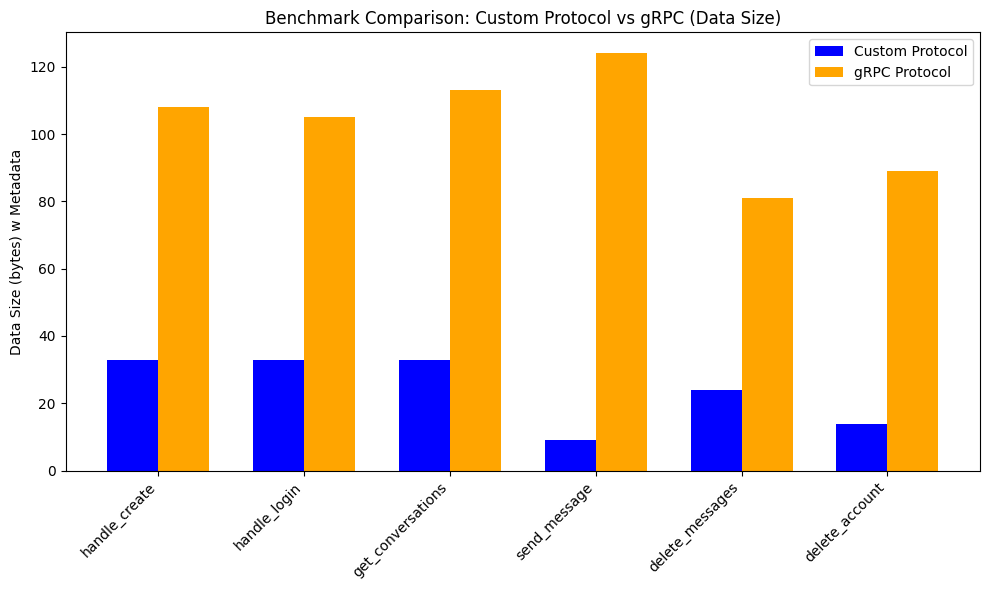

<threading.Event at 0x112de2910: set>

In [34]:
grpc_sizes = {
    "handle_create": grpc_register_request(True),
    "handle_login": benchmark_grpc_login(True),
    "get_conversations": benchmark_grpc_get_chat_history(True),
    "send_message": benchmark_grpc_send_message(True),
    "delete_messages": benchmark_grpc_delete_message(True),
    "delete_account": benchmark_grpc_delete_account(True),
}
grpc_data_sizes = [grpc_sizes[fn] for fn in grpc_sizes.keys()]

x = np.arange(len(grpc_sizes))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, custom_data_sizes, width, label='Custom Protocol', color='blue')
rects2 = ax.bar(x + width/2, grpc_data_sizes, width, label='gRPC Protocol', color='orange')

ax.set_ylabel('Data Size (bytes) w Metadata')
ax.set_title('Benchmark Comparison: Custom Protocol vs gRPC (Data Size)')
ax.set_xticks(x)
ax.set_xticklabels(custom_sizes.keys(), rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()

# Shutdown gRPC server
server.stop(None)
